In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34036 
    Total predicted counts          : 34306.54
    Total off counts                : 101858.00

    Total background counts         : 20371.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.57 s, sys: 30.9 ms, total: 3.61 s
Wall time: 3.61 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 34383 
    Total predicted counts          : 34347.94
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34005 
    Total predicted counts          : 34232.74
    Total off counts                : 101489.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 33988 
    Total predicted counts          : 34191.94
    Total off counts                : 101285.00

    Total background counts         : 20257.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_32 

    Total counts                    : 34407 
    Total predicted counts          : 34146.34
    Total off counts                : 101057.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 34080 
    Total predicted counts          : 34180.74
    Total off counts                : 101229.00

    Total background counts         : 20245.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 34058 
    Total predicted counts          : 34185.94
    Total off counts                : 101255.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 34282 
    Total predicted counts          : 34149.94
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 34118 
    Total predicted counts          : 34368.54
    Total off counts                : 102168.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_127 

    Total counts                    : 34046 
    Total predicted counts          : 34377.74
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 34223 
    Total predicted counts          : 34165.54
    Total off counts                : 101153.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_165 

    Total counts                    : 34591 
    Total predicted counts          : 34228.74
    Total off counts                : 101469.00

    Total background counts         : 20293.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_166 

    Total counts                    : 34247 
    Total predicted counts          : 34260.54
    Total off counts                : 101628.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_195 

    Total counts                    : 34164 
    Total predicted counts          : 34264.54
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_196 

    Total counts                    : 34235 
    Total predicted counts          : 34157.34
    Total off counts                : 101112.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_231 

    Total counts                    : 34276 
    Total predicted counts          : 34273.14
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_232 

    Total counts                    : 34278 
    Total predicted counts          : 34201.14
    Total off counts                : 101331.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_265 

    Total counts                    : 34246 
    Total predicted counts          : 34257.74
    Total off counts                : 101614.00

    Total background counts         : 20322.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_266 

    Total counts                    : 34268 
    Total predicted counts          : 34214.14
    Total off counts                : 101396.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_300 

    Total counts                    : 34077 
    Total predicted counts          : 34283.74
    Total off counts                : 101744.00

    Total background counts         : 20348.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_301 

    Total counts                    : 34479 
    Total predicted counts          : 34358.74
    Total off counts                : 102119.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_336 

    Total counts                    : 34391 
    Total predicted counts          : 34273.14
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_337 

    Total counts                    : 34206 
    Total predicted counts          : 34263.54
    Total off counts                : 101643.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_370 

    Total counts                    : 34352 
    Total predicted counts          : 34322.14
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_371 

    Total counts                    : 34043 
    Total predicted counts          : 34180.34
    Total off counts                : 101227.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_405 

    Total counts                    : 34138 
    Total predicted counts          : 34193.74
    Total off counts                : 101294.00

    Total background counts         : 20258.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_406 

    Total counts                    : 34517 
    Total predicted counts          : 34217.54
    Total off counts                : 101413.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 34000 
    Total predicted counts          : 34200.94
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 34333 
    Total predicted counts          : 34300.14
    Total off counts                : 101826.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_477 

    Total counts                    : 34408 
    Total predicted counts          : 34239.74
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_478 

    Total counts                    : 34204 
    Total predicted counts          : 34268.74
    Total off counts                : 101669.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_515 

    Total counts                    : 34295 
    Total predicted counts          : 34332.54
    Total off counts                : 101988.00

    Total background counts         : 20397.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_516 

    Total counts                    : 34251 
    Total predicted counts          : 34240.34
    Total off counts                : 101527.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_552 

    Total counts                    : 34191 
    Total predicted counts          : 34255.34
    Total off counts                : 101602.00

    Total background counts         : 20320.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_553 

    Total counts                    : 34513 
    Total predicted counts          : 34289.34
    Total off counts                : 101772.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 34200 
    Total predicted counts          : 34211.94
    Total off counts                : 101385.00

    Total background counts         : 20277.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 34405 
    Total predicted counts          : 34250.14
    Total off counts                : 101576.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 33774 
    Total predicted counts          : 34256.54
    Total off counts                : 101608.00

    Total background counts         : 20321.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_626 

    Total counts                    : 34088 
    Total predicted counts          : 34246.94
    Total off counts                : 101560.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_661 

    Total counts                    : 34320 
    Total predicted counts          : 34232.94
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_662 

    Total counts                    : 34135 
    Total predicted counts          : 34189.34
    Total off counts                : 101272.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_696 

    Total counts                    : 34142 
    Total predicted counts          : 34262.94
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_697 

    Total counts                    : 34193 
    Total predicted counts          : 34312.94
    Total off counts                : 101890.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_731 

    Total counts                    : 33892 
    Total predicted counts          : 34250.54
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_732 

    Total counts                    : 34504 
    Total predicted counts          : 34141.54
    Total off counts                : 101033.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_767 

    Total counts                    : 34292 
    Total predicted counts          : 34156.14
    Total off counts                : 101106.00

    Total background counts         : 20221.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_768 

    Total counts                    : 34036 
    Total predicted counts          : 34186.74
    Total off counts                : 101259.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_804 

    Total counts                    : 34304 
    Total predicted counts          : 34221.74
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 34134 
    Total predicted counts          : 34201.54
    Total off counts                : 101333.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 34155 
    Total predicted counts          : 34292.94
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_841 

    Total counts                    : 34481 
    Total predicted counts          : 34249.74
    Total off counts                : 101574.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_874 

    Total counts                    : 34349 
    Total predicted counts          : 34300.14
    Total off counts                : 101826.00

    Total background counts         : 20365.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_875 

    Total counts                    : 34177 
    Total predicted counts          : 34342.74
    Total off counts                : 102039.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_911 

    Total counts                    : 34293 
    Total predicted counts          : 34271.94
    Total off counts                : 101685.00

    Total background counts         : 20337.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_912 

    Total counts                    : 34314 
    Total predicted counts          : 34196.54
    Total off counts                : 101308.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_945 

    Total counts                    : 34057 
    Total predicted counts          : 34168.54
    Total off counts                : 101168.00

    Total background counts         : 20233.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_946 

    Total counts                    : 34235 
    Total predicted counts          : 34253.94
    Total off counts                : 101595.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_981 

    Total counts                    : 34316 
    Total predicted counts          : 34166.14
    Total off counts                : 101156.00

    Total background counts         : 20231.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_982 

    Total counts                    : 33900 
    Total predicted counts          : 34156.34
    Total off counts                : 101107.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

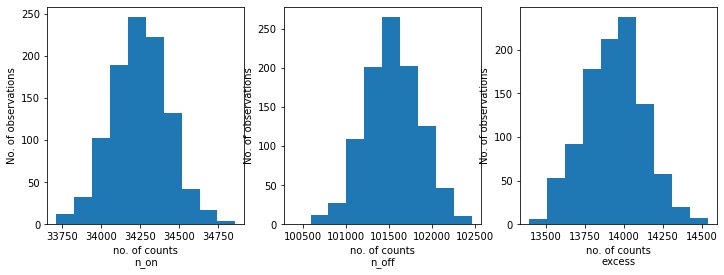

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 4min 16s, sys: 1.84 s, total: 4min 18s
Wall time: 5min


In [15]:
results

[{'index': 2.2169905875495766,
  'amplitude': 1.2845712545260467e-12,
  'lambda_': 0.2801792257657554},
 {'index': 2.2324943380030526,
  'amplitude': 1.2364897746094746e-12,
  'lambda_': 0.28570927813929065},
 {'index': 2.236715787152109,
  'amplitude': 1.2640466245835502e-12,
  'lambda_': 0.3058093664482174},
 {'index': 2.2262640878970683,
  'amplitude': 1.2624740793001813e-12,
  'lambda_': 0.302405819333618},
 {'index': 2.2385731783387843,
  'amplitude': 1.276663483135211e-12,
  'lambda_': 0.30673699196054943},
 {'index': 2.1992461618258976,
  'amplitude': 1.3302284553934254e-12,
  'lambda_': 0.3431724199735729},
 {'index': 2.2416099341604867,
  'amplitude': 1.243665549675842e-12,
  'lambda_': 0.2871674134846505},
 {'index': 2.2238247278324987,
  'amplitude': 1.2845374429121784e-12,
  'lambda_': 0.3019087052854374},
 {'index': 2.2235248230739075,
  'amplitude': 1.248766419923766e-12,
  'lambda_': 0.27479277111955186},
 {'index': 2.2589641058301537,
  'amplitude': 1.1745196406545453e-

index: 2.2199085365128965 += 0.018499191577962704


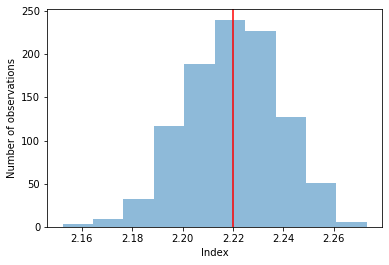

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.290859892439188e-12 += 4.8297950606788555e-14


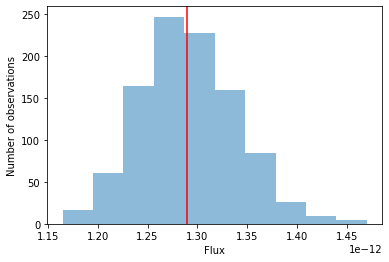

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.30122953264520774 += 0.02285608468832824


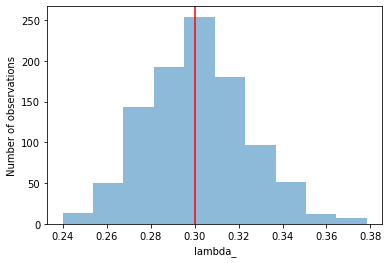

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")